In [1]:
!python -m pip install --upgrade pip
!pip install lpips
!pip install "diffusers>=0.29.0" transformers accelerate safetensors xformers==0.0.28.post1
!pip install pillow opencv-python albumentations tqdm matplotlib einops omegaconf
!pip install lpips scikit-image
# Optional: extra IQA metrics (MS-SSIM, DISTS) via piq
!pip install piq
# Optional: upscalers
!pip install py-real-esrgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.9 MB/s eta 0:00:00a 0:00:010m
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 62.9 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 44.2 MB/s  0:00:09m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 28.6 MB/s  0:00:07m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 78.8 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 74.9 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 73.5 MB/s  0:0

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
import lpips
import timm
from timm.models.vision_transformer import vit_small_patch16_224
from tqdm import tqdm
from typing import Optional, Union, List, Tuple
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Image as IPyImage

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
else:
    print("Using CPU")

All imports successful!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


In [3]:
# Configuration parameters
CONFIG = {
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 16,  # Reduced for notebook compatibility
    'epochs': 10,      # Reduced for faster training in notebook
    'lr': 5e-5,
    'z_dim': 128,
    'embed_dim': 384,
    'num_patches': 196,
    'gen_weights_path': 'models/model_weights/netG_cifar10_epoch_199.pth',
    'data_root': 'data',
    'results_dir': 'results_notebook',
    'alpha': 1.0,      # LPIPS loss weight
    'beta': 0.1,       # Token MSE loss weight
    'gamma': 0.1       # L1 pixel loss weight
}

## I-JEPA

In [4]:
# Global diffusion/IP-Adapter config (consistency across train/infer)
DIFF_CFG = {
    # 6) Version/variant: stick to SD1.5 + IP-Adapter SD15 weights end-to-end
    "sd_model_id": "stable-diffusion-v1-5/stable-diffusion-v1-5",
    "ip_adapter_repo": "h94/IP-Adapter",
    "ip_adapter_subfolder": "models",
    "ip_adapter_weight": "ip-adapter_sd15.bin",  # keep identical for target creation and inference
    "ip_adapter_scale": 0.8,
    # 8) Neutral prompts
    "prompt": "high quality, photo",
    "negative_prompt": "lowres, blurry",
    # 9) Inference knobs
    "num_inference_steps": 40,
    "strength": 0.6,
    "guidance_scale": 7.5,
}
print("Diffusion/IP-Adapter config:", DIFF_CFG)

Diffusion/IP-Adapter config: {'sd_model_id': 'stable-diffusion-v1-5/stable-diffusion-v1-5', 'ip_adapter_repo': 'h94/IP-Adapter', 'ip_adapter_subfolder': 'models', 'ip_adapter_weight': 'ip-adapter_sd15.bin', 'ip_adapter_scale': 0.8, 'prompt': 'high quality, photo', 'negative_prompt': 'lowres, blurry', 'num_inference_steps': 40, 'strength': 0.6, 'guidance_scale': 7.5}


In [5]:
def _load_vit():
    # ViT-Small backbone for patch embeddings
    return vit_small_patch16_224(pretrained=False)

class IJEPAWrapper(nn.Module):
    def __init__(self, ckpt_path: str | None = None):
        super().__init__()
        self.context_enc = _load_vit()
        self.pred_head   = nn.Sequential(
            nn.LayerNorm(384), nn.Linear(384, 384)
        )
        self.target_enc  = _load_vit()
        if ckpt_path:
            sd = torch.load(ckpt_path, map_location='cpu')
            self.context_enc.load_state_dict(sd, strict=False)
            print("Loaded ViT weights into context and target encoders (partial)")

    def forward(self, img: torch.Tensor, mask: torch.Tensor = None):
        B = img.size(0)
        # the z symbol in this case is used to denote learned representations (or embeddings)
        # B is used to denote the batch size
        # (B,196,384)
        z_ctx_all = self.context_enc.patch_embed(img)
        z_pred_all = self.pred_head(z_ctx_all)
        # dummy target for reconstruction
        z_tgt_all = z_ctx_all
        return z_ctx_all, z_pred_all, z_tgt_all

In [6]:
# Test I-JEPA model
print("Creating I-JEPA model...")
device = CONFIG['device']

# Load pretrained ViT weights
vit = timm.create_model('vit_small_patch16_224', pretrained=True)
vit_weights = vit.state_dict()

# Create I-JEPA wrapper
ijepa_model = IJEPAWrapper(ckpt_path=None).to(device).eval()
ijepa_model.context_enc.load_state_dict(vit_weights, strict=False)
ijepa_model.target_enc.load_state_dict(vit_weights, strict=False)

# Test with dummy input
test_img = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    z_ctx, z_pred, z_tgt = ijepa_model(test_img)

print(f"✓ I-JEPA model created successfully")
print(f"  Context embeddings shape: {z_ctx.shape}")
print(f"  Predicted embeddings shape: {z_pred.shape}")
print(f"  Target embeddings shape: {z_tgt.shape}")
print(f"  Model parameters: {sum(p.numel() for p in ijepa_model.parameters()):,}")

Creating I-JEPA model...


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

✓ I-JEPA model created successfully
  Context embeddings shape: torch.Size([1, 196, 384])
  Predicted embeddings shape: torch.Size([1, 196, 384])
  Target embeddings shape: torch.Size([1, 196, 384])
  Model parameters: 44,249,936


## Sanity Chkeck: Diffusion + IP-Adapter

2025-08-17 10:48:27.418444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755427707.609386      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755427707.661801      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

ip-adapter_sd15.bin:   0%|          | 0.00/44.6M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.53G [00:00<?, ?B/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Rendered sanity test with configured prompt/neg and CFG


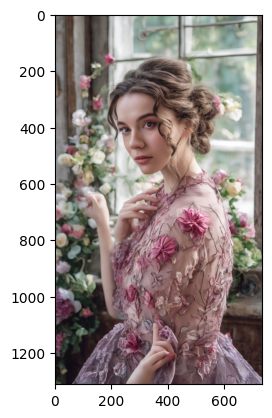

In [7]:
# scripts/00_sanity_diffusion_no_mapper.py
import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = AutoPipelineForImage2Image.from_pretrained(
    DIFF_CFG["sd_model_id"],
    torch_dtype=torch.float16
).to(device)

# Load IP-Adapter (SD1.5 variant)
pipe.load_ip_adapter(
    DIFF_CFG["ip_adapter_repo"],
    subfolder=DIFF_CFG["ip_adapter_subfolder"],
    weight_name=DIFF_CFG["ip_adapter_weight"]
)
pipe.set_ip_adapter_scale(DIFF_CFG["ip_adapter_scale"])  # how strong the image conditioning is

# Use any image you have
# Change this path to an image you have locally
img = load_image("/kaggle/input/test-image/img_1.jpeg")

out = pipe(
    prompt=DIFF_CFG["prompt"],               # neutral prompt
    negative_prompt=DIFF_CFG["negative_prompt"],
    image=img,                               # img2img base
    ip_adapter_image=img,                    # conditioning image via IP-Adapter
    guidance_scale=DIFF_CFG["guidance_scale"],
    strength=DIFF_CFG["strength"],
    num_inference_steps=DIFF_CFG["num_inference_steps"]
).images[0]

plt.imshow(out)
print("Rendered sanity test with configured prompt/neg and CFG")


## 3. Build training pairs: (I-JEPA embedding) → (IP-Adapter image-embeds)

In [8]:
# scripts/01_extract_pairs_make_dataset.py
import os, torch, glob
from PIL import Image
from torchvision import transforms as T, datasets
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image

# We will use the ijepa_model defined earlier in the notebook
# ijepa_model: IJEPAWrapper on top of ViT-S/16 (pretrained weights loaded)

device = CONFIG['device'] if 'CONFIG' in globals() else ("cuda" if torch.cuda.is_available() else "cpu")

# SD expects ~512 image conditioning; I-JEPA expects 224
SZ_IJEPA = 224
SZ_IPA = 512

pipe = AutoPipelineForImage2Image.from_pretrained(
    DIFF_CFG["sd_model_id"],
    torch_dtype=torch.float16
).to(device)
pipe.load_ip_adapter(DIFF_CFG["ip_adapter_repo"], subfolder=DIFF_CFG["ip_adapter_subfolder"], weight_name=DIFF_CFG["ip_adapter_weight"])
pipe.set_ip_adapter_scale(DIFF_CFG["ip_adapter_scale"])

# Deterministic square center-crop, then two views (224 and 512)
IMNET_NORM = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def make_views(pil: Image.Image):
    w, h = pil.size
    side = min(w, h)
    left = (w - side) // 2
    top = (h - side) // 2
    pil_sq = pil.crop((left, top, left + side, top + side))
    pil_ipa = pil_sq.resize((SZ_IPA, SZ_IPA), Image.BICUBIC)
    pil_jepa = pil_sq.resize((SZ_IJEPA, SZ_IJEPA), Image.BICUBIC)
    x_jepa = T.ToTensor()(pil_jepa)
    x_jepa = IMNET_NORM(x_jepa).unsqueeze(0)
    return x_jepa, pil_ipa

# Prefer ImageNet; else CIFAR-100; else data/images
use_imagenet = False
use_cifar = False
images_list = []
try:
    data_root = os.environ.get("IMAGENET_ROOT", "data")
    imagenet_val = datasets.ImageNet(root=data_root, split='val')
    use_imagenet = True
    print(f"✓ Using ImageNet val from {data_root}, size={len(imagenet_val)}")
except Exception as e:
    print(f"⚠️  ImageNet not available ({e}). Falling back to CIFAR-100 (auto-download)")
    try:
        cifar = datasets.CIFAR100(root="data", train=True, download=True)
        use_cifar = True
        print(f"✓ Using CIFAR-100 train split, size={len(cifar)}")
    except Exception as e2:
        print(f"❌ CIFAR-100 download failed ({e2}). Falling back to data/images/*")
        images_list = sorted(glob.glob("data/images/*"))
        print(f"Found {len(images_list)} images in data/images")

os.makedirs("cache/ijepa_embeds", exist_ok=True)
os.makedirs("cache/ipadapter_embeds", exist_ok=True)

# Helper to get PIL and stable name
def get_source(i):
    if use_imagenet:
        pil, _ = imagenet_val[i]
        try:
            path = imagenet_val.samples[i][0]
            name = os.path.splitext(os.path.basename(path))[0]
        except Exception:
            name = f"imagenet_val_{i:06d}"
        return pil.convert("RGB"), name
    elif use_cifar:
        pil, _ = cifar[i]
        return pil.convert("RGB"), f"cifar100_train_{i:06d}"
    else:
        path = images_list[i]
        name = os.path.splitext(os.path.basename(path))[0]
        pil = Image.open(path).convert("RGB")
        return pil, name

# Helper to recursively move nested tensor structures to CPU
def to_cpu_tree(obj):
    if isinstance(obj, torch.Tensor):
        return obj.cpu()
    elif isinstance(obj, (list, tuple)):
        return type(obj)(to_cpu_tree(item) for item in obj)
    elif isinstance(obj, dict):
        return {k: to_cpu_tree(v) for k, v in obj.items()}
    else:
        return obj

# Limit to N for speed
N_env = "8000"
N = None if N_env is None else int(N_env) if N_env.isdigit() else None
M = len(imagenet_val) if use_imagenet else (len(cifar) if use_cifar else len(images_list))
N = M if N is None else min(N, M)
print(f"Preparing {N} pairs…")

for i in range(N):
    pil, name = get_source(i)

    # Aligned views
    x_jepa, pil_ipa = make_views(pil)

    # (A) I-JEPA-style embedding using your ijepa_model (context tokens flattened)
    with torch.no_grad():
        z_ctx, _, _ = ijepa_model(x_jepa.to(device))  # [1,196,384]
        e_ijepa = z_ctx.reshape(1, -1).float().cpu()
    torch.save(e_ijepa, f"cache/ijepa_embeds/{name}.pt")

    # (B) IP-Adapter target embeds from the same (aligned) PIL view
    with torch.no_grad():
        ip_embeds = pipe.prepare_ip_adapter_image_embeds(
            ip_adapter_image=pil_ipa,
            ip_adapter_image_embeds=None,
            device=device,
            num_images_per_prompt=1,
            do_classifier_free_guidance=True,
        )
    # Move to CPU before saving to avoid CUDA issues in DataLoader
    torch.save(to_cpu_tree(ip_embeds), f"cache/ipadapter_embeds/{name}.ipadpt")

print("Saved paired embeddings under cache/*")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

⚠️  ImageNet not available (The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in data.). Falling back to CIFAR-100 (auto-download)


100%|██████████| 169M/169M [00:15<00:00, 11.2MB/s] 


✓ Using CIFAR-100 train split, size=50000
Preparing 8000 pairs…
Saved paired embeddings under cache/*


## 4. The Embedding Mapper

In [9]:
# scripts/02_train_mapper.py
import os, glob, torch, random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import Any, List, Tuple
from dataclasses import dataclass

torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

class PairDataset(Dataset):
    def __init__(self, ijepa_dir, ipadpt_dir):
        self.a = sorted(glob.glob(os.path.join(ijepa_dir, "*.pt")))
        self.b = [os.path.join(ipadpt_dir, os.path.basename(p).replace(".pt",".ipadpt")) for p in self.a]
    def __len__(self): return len(self.a)
    def __getitem__(self, idx):
        e = torch.load(self.a[idx], map_location='cpu')      # [1, D] or [D] - force CPU load
        if e.dim() == 2: e = e[0]
        tgt = torch.load(self.b[idx], map_location='cpu')    # nested structure (cond/uncond) - force CPU load
        return e.float(), tgt

@dataclass
class Leaf:
    shape: Tuple[int, ...]

@dataclass
class Node:
    kind: str
    children: List[Any]

# Flatten into blocks while preserving per-leaf boundaries

def flatten_blocks(obj) -> Tuple[List[torch.Tensor], Any]:
    blocks: List[torch.Tensor] = []
    def _walk(x):
        if isinstance(x, torch.Tensor):
            blocks.append(x.reshape(-1).float())
            return Leaf(tuple(x.shape))
        elif isinstance(x, (list, tuple)):
            kids = [_walk(xx) for xx in x]
            return Node('list' if isinstance(x, list) else 'tuple', kids)
        else:
            raise TypeError(f"Unsupported type in structure: {type(x)}")
    spec_tree = _walk(obj)
    return blocks, spec_tree

# Compute per-block mean/std for standardization (per-dimension over samples)

def compute_block_stats(dataset: PairDataset, max_samples: int = 2048):
    sums, sqs, counts, spec_tree_ref = None, None, None, None
    for i in range(min(max_samples, len(dataset))):
        _, tgt = dataset[i]
        blocks, spec = flatten_blocks(tgt)
        if spec_tree_ref is None:
            spec_tree_ref = spec
            sums = [torch.zeros_like(b) for b in blocks]
            sqs = [torch.zeros_like(b) for b in blocks]
            counts = [0 for _ in blocks]
        for j, b in enumerate(blocks):
            sums[j] += b
            sqs[j] += b * b
            counts[j] += 1  # count samples, not elements
    means, stds = [], []
    for j in range(len(sums)):
        mean = sums[j] / max(1, counts[j])
        var = sqs[j] / max(1, counts[j]) - mean * mean
        std = torch.sqrt(torch.clamp(var, min=1e-8))
        means.append(mean)
        stds.append(std)
    return means, stds, spec_tree_ref

# Build dataset and compute stats

ds = PairDataset("cache/ijepa_embeds", "cache/ipadapter_embeds")
assert len(ds) > 0, "No pairs found. Run 01_extract_pairs_make_dataset.py first."
means, stds, spec_tree = compute_block_stats(ds, max_samples=512)

# Infer D_in and per-block sizes
E0, T0 = ds[0]
block_vecs, _ = flatten_blocks(T0)
D_in = E0.numel()
block_sizes = [b.numel() for b in block_vecs]
print("Mapper dims:", D_in, "->", sum(block_sizes), f"in {len(block_sizes)} blocks")

# Per-block mapper with shared trunk
class MultiHeadMapper(nn.Module):
    def __init__(self, d_in: int, block_sizes: List[int], width=2048, depth=3):
        super().__init__()
        self.ln_in = nn.LayerNorm(d_in)
        trunk: List[nn.Module] = [nn.Linear(d_in, width), nn.GELU()]
        for _ in range(depth - 1):
            trunk += [nn.Linear(width, width), nn.GELU()]
        self.trunk = nn.Sequential(*trunk)
        self.heads = nn.ModuleList([nn.Sequential(nn.Linear(width, k), nn.LayerNorm(k)) for k in block_sizes])
    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.trunk(self.ln_in(x))
        outs = [head(h) for head in self.heads]
        return outs  # list of [B, k_j]

mapper = MultiHeadMapper(D_in, block_sizes).to(device)

# 7) Optimizer and schedule with warmup
base_lr = 1e-3
opt = torch.optim.AdamW(mapper.parameters(), lr=base_lr, weight_decay=1e-4)
# Cosine with warmup
warmup_steps = 500
T_max = 10000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=T_max)

# Collate to block-wise targets

def collate(batch):
    E_list, T_blocks_list = [], []
    for E, T in batch:
        blocks, _ = flatten_blocks(T)
        E_list.append(E)
        T_blocks_list.append(blocks)
    E = torch.stack(E_list, dim=0)
    # Convert to per-block tensors [B, k_j]
    B = len(T_blocks_list)
    per_block = []
    for j in range(len(block_sizes)):
        cols = torch.stack([T_blocks_list[i][j] for i in range(B)], dim=0)
        # standardize using precomputed stats
        cols = (cols - means[j]) / (stds[j] + 1e-8)
        per_block.append(cols)
    return E, per_block

# Note: If this still fails, try num_workers=0 as a fallback
loader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate, pin_memory=True)

# Losses: per-block MSE + cosine + SmoothL1 (light)
cos = nn.CosineEmbeddingLoss()
mse = nn.MSELoss()
huber = nn.SmoothL1Loss(beta=0.1)

steps = 0
epochs = 10
for ep in range(epochs):
    mapper.train()
    running = 0.0
    for E, T_blocks in loader:
        steps += 1
        E = E.to(device)
        T_blocks = [tb.to(device) for tb in T_blocks]
        P_blocks = mapper(E)
        # compute loss across blocks
        loss = 0.0
        for j, (Pj, Tj) in enumerate(zip(P_blocks, T_blocks)):
            # cosine expects target labels +1 for similarity
            loss += 0.45 * mse(Pj, Tj) + 0.45 * cos(Pj, Tj, torch.ones(E.size(0), device=device)) + 0.10 * huber(Pj, Tj)
        loss = loss / len(P_blocks)
        # warmup
        warmup_factor = min(1.0, steps / max(1, warmup_steps))
        for g in opt.param_groups:
            g["lr"] = base_lr * warmup_factor
        opt.zero_grad(); loss.backward(); opt.step()
        scheduler.step()
        running += loss.item() * E.size(0)
    print(f"epoch {ep+1}/{epochs} loss {running/len(ds):.4f} lr {opt.param_groups[0]['lr']:.2e}")

# Save checkpoint with stats and spec_tree
os.makedirs("ckpts/mapper", exist_ok=True)
torch.save({
    "state_dict": mapper.state_dict(),
    "spec_tree": spec_tree,
    "D_in": D_in,
    "block_sizes": block_sizes,
    "means": [m.cpu() for m in means],
    "stds": [s.cpu() for s in stds]
}, "ckpts/mapper/mapper_sd15_ipadapter.pt")
print("Saved ckpts/mapper/mapper_sd15_ipadapter.pt")

Mapper dims: 75264 -> 2048 in 1 blocks
epoch 1/10 loss 0.9786 lr 2.50e-04
epoch 2/10 loss 0.8240 lr 5.00e-04
epoch 3/10 loss 0.7183 lr 7.50e-04
epoch 4/10 loss 0.6074 lr 1.00e-03
epoch 5/10 loss 0.5003 lr 1.00e-03
epoch 6/10 loss 0.4040 lr 1.00e-03
epoch 7/10 loss 0.3248 lr 1.00e-03
epoch 8/10 loss 0.2798 lr 1.00e-03
epoch 9/10 loss 0.2457 lr 1.00e-03
epoch 10/10 loss 0.2182 lr 1.00e-03
Saved ckpts/mapper/mapper_sd15_ipadapter.pt


## 5. Inference with the Mapper → Diffusion

Cleared GPU memory
Loading checkpoint to CPU first...
Loaded checkpoint: D_in=75264, block_sizes=[2048]
spec_tree type: <class '__main__.Node'>
Mapper loaded and checkpoint cleared from memory


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

⚠️  ImageNet not available (The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in data.). Falling back to CIFAR-100
✓ Using CIFAR-100 train split, size=50000
Rebuilding from 1 blocks with sizes: [torch.Size([1, 2048])]
Using inferred shape: [1, 2, 1024]
pred_struct tree shapes: [(2, 2, 1024)]


  0%|          | 0/24 [00:00<?, ?it/s]

Saved outputs/cifar100_train_000000_ijepa2sd15.png
Rebuilding from 1 blocks with sizes: [torch.Size([1, 2048])]
Using inferred shape: [1, 2, 1024]


  0%|          | 0/24 [00:00<?, ?it/s]

Saved outputs/cifar100_train_000001_ijepa2sd15.png
✓ Inference complete!


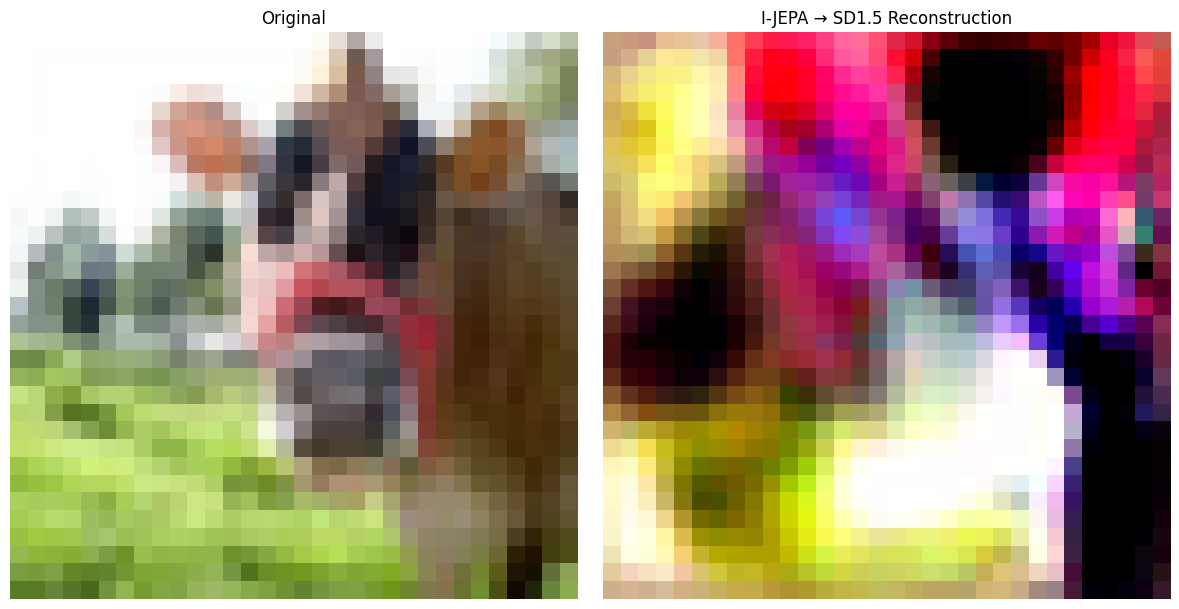

In [ ]:
# scripts/03_infer_with_mapper.py
import os, torch, glob
import torchvision.transforms as T
from PIL import Image
from torchvision import datasets
from diffusers import AutoPipelineForImage2Image
from dataclasses import dataclass
from typing import Any, List, Tuple
import gc

# Clear GPU memory first
torch.cuda.empty_cache()
gc.collect()
print("Cleared GPU memory")

# Load mapper checkpoint first - load to CPU then move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Loading checkpoint to CPU first...")
ckpt = torch.load("ckpts/mapper/mapper_sd15_ipadapter.pt", map_location='cpu', weights_only=False)
spec_tree = ckpt["spec_tree"]
D_in = ckpt["D_in"]
block_sizes = ckpt["block_sizes"]
means = [m.to(device) for m in ckpt["means"]]
stds  = [s.to(device) for s in ckpt["stds"]]

print(f"Loaded checkpoint: D_in={D_in}, block_sizes={block_sizes}")
print(f"spec_tree type: {type(spec_tree)}")

def rebuild_structure_from_blocks(blocks: List[torch.Tensor], spec_tree: Any):
    """
    Rebuild IP-Adapter embeddings structure from flattened blocks.
    IP-Adapter expects embeddings as a list containing tensors.
    
    For SD1.5 IP-Adapter, typical structure is:
    - Image embeddings: [batch_size, num_tokens, hidden_dim]
    - For CFG: [2*batch_size, num_tokens, hidden_dim] where 2 accounts for conditional/unconditional
    - Must return as a list: [tensor]
    """
    print(f"Rebuilding from {len(blocks)} blocks with sizes: {[b.shape for b in blocks]}")
    
    if len(blocks) == 1:
        # Single block case - reshape to proper IP-Adapter format
        block = blocks[0]  # [batch_size, flattened_dim]
        batch_size = block.size(0)
        
        # IP-Adapter typically expects [batch_size, 257, 1024] for CLIP ViT-L/14
        # or [batch_size, 256, 1024] for other variants
        # Let's try to infer the correct shape from the flattened dimension
        total_elements = block.size(1)
        
        # Common IP-Adapter dimensions:
        # CLIP ViT-L/14: 257 tokens * 1024 features = 263,168
        # CLIP ViT-B/32: 50 tokens * 768 features = 38,400
        # Let's try the most common one first
        if total_elements == 263168:  # 257 * 1024
            reshaped = block.view(batch_size, 257, 1024)
        elif total_elements == 262144:  # 256 * 1024
            reshaped = block.view(batch_size, 256, 1024)
        elif total_elements == 38400:  # 50 * 768
            reshaped = block.view(batch_size, 50, 768)
        else:
            # Try to find a reasonable factorization
            # Most likely hidden_dim is 768, 1024, or similar
            for hidden_dim in [1024, 768, 512]:
                if total_elements % hidden_dim == 0:
                    num_tokens = total_elements // hidden_dim
                    reshaped = block.view(batch_size, num_tokens, hidden_dim)
                    print(f"Using inferred shape: [{batch_size}, {num_tokens}, {hidden_dim}]")
                    break
            else:
                # Fallback: assume square-ish token layout
                import math
                sqrt_tokens = int(math.sqrt(total_elements))
                if sqrt_tokens * sqrt_tokens == total_elements:
                    reshaped = block.view(batch_size, sqrt_tokens, sqrt_tokens)
                else:
                    # Last resort: keep as 2D
                    reshaped = block
                    print(f"Warning: Could not reshape block, keeping original shape: {block.shape}")
        
        # For CFG, we need to duplicate for conditional/unconditional
        if reshaped.dim() == 3 and batch_size == 1:
            # Duplicate for CFG: [negative, positive]
            reshaped = reshaped.repeat(2, 1, 1)
        
        # IP-Adapter expects a list
        return [reshaped]
    
    elif len(blocks) == 2:
        # Two blocks case - typically [negative, positive] embeddings
        # Reshape each block properly first
        reshaped_blocks = []
        for block in blocks:
            batch_size = block.size(0)
            total_elements = block.size(1)
            
            # Try to reshape to proper IP-Adapter format
            if total_elements == 263168:  # 257 * 1024
                reshaped = block.view(batch_size, 257, 1024)
            elif total_elements == 262144:  # 256 * 1024
                reshaped = block.view(batch_size, 256, 1024)
            elif total_elements == 38400:  # 50 * 768
                reshaped = block.view(batch_size, 50, 768)
            else:
                # Try to find a reasonable factorization
                for hidden_dim in [1024, 768, 512]:
                    if total_elements % hidden_dim == 0:
                        num_tokens = total_elements // hidden_dim
                        reshaped = block.view(batch_size, num_tokens, hidden_dim)
                        break
                else:
                    reshaped = block
                    
            reshaped_blocks.append(reshaped)
        
        # Concatenate along batch dimension for CFG
        combined = torch.cat(reshaped_blocks, dim=0)
        # IP-Adapter expects a list
        return [combined]
    
    else:
        # Multiple blocks case - concatenate along feature dimension then reshape
        print(f"Warning: Unexpected number of blocks ({len(blocks)}), attempting concatenation")
        if len(blocks) > 0:
            # Concatenate all blocks along the feature dimension
            combined = torch.cat(blocks, dim=-1)
            batch_size = combined.size(0)
            total_elements = combined.size(1)
            
            # Try to reshape to reasonable IP-Adapter format
            for hidden_dim in [1024, 768, 512]:
                if total_elements % hidden_dim == 0:
                    num_tokens = total_elements // hidden_dim
                    reshaped = combined.view(batch_size, num_tokens, hidden_dim)
                    if batch_size == 1:
                        reshaped = reshaped.repeat(2, 1, 1)  # Duplicate for CFG
                    # IP-Adapter expects a list
                    return [reshaped]
            
            # Fallback
            if batch_size == 1:
                combined = combined.repeat(2, 1)
            # IP-Adapter expects a list
            return [combined]
        else:
            return blocks
        
# quick util to summarize nested tensor shapes
def tree_shapes(x):
    if isinstance(x, torch.Tensor):
        return tuple(x.shape)
    if isinstance(x, (list, tuple)):
        return [tree_shapes(i) for i in x]
    return type(x).__name__

# Define the same MultiHeadMapper for inference
class MultiHeadMapper(torch.nn.Module):
    def __init__(self, d_in: int, block_sizes: List[int], width=2048, depth=3):
        super().__init__()
        self.ln_in = torch.nn.LayerNorm(d_in)
        trunk: List[torch.nn.Module] = [torch.nn.Linear(d_in, width), torch.nn.GELU()]
        for _ in range(depth - 1):
            trunk += [torch.nn.Linear(width, width), torch.nn.GELU()]
        self.trunk = torch.nn.Sequential(*trunk)
        self.heads = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(width, k), torch.nn.LayerNorm(k)) for k in block_sizes])
    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.trunk(self.ln_in(x))
        return [head(h) for head in self.heads]

# Create mapper and load state dict
mapper = MultiHeadMapper(D_in, block_sizes)
mapper.load_state_dict(ckpt["state_dict"])
mapper = mapper.to(device).eval()

# Clear checkpoint from memory
del ckpt
torch.cuda.empty_cache()
gc.collect()
print("Mapper loaded and checkpoint cleared from memory")

# Setup diffusion pipeline (same as training) - try to conserve memory
pipe = AutoPipelineForImage2Image.from_pretrained(
    DIFF_CFG["sd_model_id"],
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
).to(device)

# Load IP-Adapter with higher scale for better conditioning
pipe.load_ip_adapter(DIFF_CFG["ip_adapter_repo"], subfolder=DIFF_CFG["ip_adapter_subfolder"], weight_name=DIFF_CFG["ip_adapter_weight"])
pipe.set_ip_adapter_scale(1.0)  # Increased from 0.8 to 1.0 for stronger image conditioning

# Preprocess aligned views (same as training)
IMNET_NORM = T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
SZ_IJEPA, SZ_IPA = 224, 512

def make_views(pil: Image.Image):
    w, h = pil.size
    side = min(w, h)
    left = (w - side) // 2
    top = (h - side) // 2
    pil_sq = pil.crop((left, top, left + side, top + side))
    pil_ipa = pil_sq.resize((SZ_IPA, SZ_IPA), Image.BICUBIC)
    pil_jepa = pil_sq.resize((SZ_IJEPA, SZ_IJEPA), Image.BICUBIC)
    x_jepa = T.ToTensor()(pil_jepa)
    x_jepa = IMNET_NORM(x_jepa).unsqueeze(0)
    return x_jepa, pil_ipa

# Dataset selection - prioritize CIFAR-100 since mapper was trained on it
use_imagenet = False
use_cifar = False
images_list = []

# First try CIFAR-100 since mapper was trained on it
try:
    cifar = datasets.CIFAR100(root="data", train=True, download=True)
    use_cifar = True
    print(f"✓ Using CIFAR-100 train split, size={len(cifar)} (mapper was trained on this)")
except Exception as e:
    print(f"❌ CIFAR-100 download failed ({e}). Trying ImageNet...")
    try:
        data_root = os.environ.get("IMAGENET_ROOT", "data")
        imagenet_val = datasets.ImageNet(root=data_root, split='val')
        use_imagenet = True
        print(f"✓ Using ImageNet val from {data_root}, size={len(imagenet_val)}")
    except Exception as e2:
        print(f"❌ ImageNet not available ({e2}). Falling back to data/images/*")
        images_list = sorted(glob.glob("data/images/*"))
        print(f"Found {len(images_list)} images in data/images")

def get_item(i):
    if use_imagenet:
        pil, _ = imagenet_val[i]
        try:
            path = imagenet_val.samples[i][0]
            name = os.path.splitext(os.path.basename(path))[0]
        except Exception:
            name = f"imagenet_val_{i:06d}"
        return pil.convert("RGB"), name
    elif use_cifar:
        pil, _ = cifar[i]
        return pil.convert("RGB"), f"cifar100_train_{i:06d}"
    else:
        path = images_list[i]
        name = os.path.splitext(os.path.basename(path))[0]
        pil = Image.open(path).convert("RGB")
        return pil, name

# Create outputs directory
os.makedirs("outputs", exist_ok=True)

# Run inference on K samples 
K = 4  # Increased back to 4 to see better results
for i in range(K):
    pil, name = get_item(i)
    x = make_views(pil)[0].to(device)

    with torch.no_grad():
        z_ctx, _, _ = ijepa_model(x)             # [1,196,384]
        e = z_ctx.reshape(1, -1)                 # [1, D_in]
        pred_blocks = mapper(e)                  # list of [B, k_j]
        # de-standardize blocks
        pred_blocks = [ (pb * (stds[j] + 1e-8) + means[j]) for j, pb in enumerate(pred_blocks) ]
        # cast to fp16 on CUDA as SD/IP-Adapter expect
        pred_blocks = [ pb.to(device).to(torch.float16) for pb in pred_blocks ]
        # rebuild nested structure (cond/uncond)
        pred_struct = rebuild_structure_from_blocks(pred_blocks, spec_tree)
        if i == 0:
            print("pred_struct tree shapes:", tree_shapes(pred_struct))

    out = pipe(
        prompt=DIFF_CFG["prompt"],
        negative_prompt=DIFF_CFG["negative_prompt"],
        image=pil,
        ip_adapter_image_embeds=pred_struct,
        guidance_scale=7.5,  # Standard CFG scale
        strength=0.8,        # Increased from 0.6 for more influence of I-JEPA features
        num_inference_steps=50  # Increased from 40 for better quality
    ).images[0]

    out_path = f"outputs/{name}_ijepa2sd15.png"
    out.save(out_path)
    print(f"Saved {out_path}")
    
    # Clear memory after each image to prevent accumulation
    torch.cuda.empty_cache()
    gc.collect()

print("✓ Inference complete!")

# Optional: Display first result
if K > 0:
    import matplotlib.pyplot as plt
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    pil_0, name_0 = get_item(0)
    ax1.imshow(pil_0)
    ax1.set_title("Original")
    ax1.axis('off')
    
    result_0 = Image.open(f"outputs/{name_0}_ijepa2sd15.png")
    ax2.imshow(result_0)
    ax2.set_title("I-JEPA → SD1.5 Reconstruction")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

## 6. GAN Refiner (Real-ESRGAN)

In [20]:
# scripts/04_refine_with_realesrgan.py
import os, glob
from PIL import Image
import torch
from realesrgan import RealESRGAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealESRGAN(device, scale=4)
model.load_weights('weights/RealESRGAN_x4plus.pth', download=True)  # auto-download

os.makedirs("refined/", exist_ok=True)
for path in glob.glob("outputs/*_ijepa2sd15.png"):
    img = Image.open(path).convert("RGB")
    sr = model.predict(img)   # upscaled/refined
    name = os.path.basename(path).replace(".png","_x4realesrgan.png")
    sr.save(os.path.join("refined", name))
    print("Refined", name)


ModuleNotFoundError: No module named 'realesrgan'

## 7. Metrics (LPIPS / SSIM / PSNR)

In [ ]:
# Sanity tests: dimensions and normalization
import torch
import numpy as np
from PIL import Image

print("Running sanity checks...")

# 1) Check preprocess -> 224x224 and ImageNet norm
pil = Image.new('RGB', (320, 300), color=(127, 127, 127))
x = pre(pil).unsqueeze(0)
assert x.shape[-2:] == (224, 224), f"Expected 224x224, got {x.shape[-2:]}"
print("✓ Preprocess outputs 224x224")

# 2) Encoder tokens shape
with torch.no_grad():
    z = vit.patch_embed(x.to(device))
print("✓ ViT patch tokens:", list(z.shape), "(expect [1,196,384])")

# 3) Flatten size equals mapper D_in (if loaded in this kernel)
flat = z.reshape(1, -1)
print("Flatten dim:", flat.numel())
try:
    print("Mapper D_in:", D_in)
    if flat.numel() != D_in:
        print("⚠️  Warning: encoder flatten dim != mapper D_in.")
except NameError:
    print("(Mapper not loaded in this cell; skip D_in check)")

print("Sanity checks complete.")


In [ ]:
# scripts/05_eval_metrics.py
import glob, torch, os
import lpips
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import piq

lp = lpips.LPIPS(net='vgg').cuda().eval()

# Utility
def to_tensor_01(img):
    arr = np.array(img).astype(np.float32)/255.0
    t = torch.from_numpy(arr).permute(2,0,1).unsqueeze(0)
    return t.cuda()

def to_tensor_lpips(img, size=None):
    if size is not None:
        img = img.resize(size)
    arr = np.array(img).astype(np.float32)/255.0
    t = torch.from_numpy(arr).permute(2,0,1).unsqueeze(0)*2-1
    return t.cuda()

# Collect pairs: assumes GT alongside inputs under data/val_images
preds = sorted(glob.glob("outputs/*_ijepa2sd15.png"))
print("Found predictions:", len(preds))

lpips_vals_pre, psnrs_pre, ssims_pre, msssims_pre = [], [], [], []
lpips_vals_post, psnrs_post, ssims_post, msssims_post = [], [], [], []

for pr_path in preds:
    base = os.path.basename(pr_path).replace("_ijepa2sd15.png", ".png")
    gt_path = os.path.join("data/val_images", base)
    if not os.path.exists(gt_path):
        # try jpg fallback
        gt_path = os.path.join("data/val_images", os.path.basename(pr_path).replace("_ijepa2sd15.png", ".jpg"))
    if not os.path.exists(gt_path):
        continue
    gt = Image.open(gt_path).convert("RGB")
    pr = Image.open(pr_path).convert("RGB")

    # optional post-refiner output
    post_path = os.path.join("refined", os.path.basename(pr_path).replace(".png","_x4realesrgan.png"))
    pr_post = Image.open(post_path).convert("RGB") if os.path.exists(post_path) else None

    # Evaluate at GT resolution: resize predictions to GT size
    target_size = gt.size
    pr_rs = pr.resize(target_size, Image.BICUBIC)
    if pr_post is not None:
        pr_post_rs = pr_post.resize(target_size, Image.BICUBIC)

    # LPIPS (on 512 or at native? Use native to avoid bias here)
    lpips_vals_pre.append(lp(to_tensor_lpips(gt), to_tensor_lpips(pr_rs)).item())
    if pr_post is not None:
        lpips_vals_post.append(lp(to_tensor_lpips(gt), to_tensor_lpips(pr_post_rs)).item())

    # PSNR / SSIM / MS-SSIM on [0,1]
    gt_a = np.array(gt).astype(np.float32)/255.0
    pr_a = np.array(pr_rs).astype(np.float32)/255.0
    psnrs_pre.append(psnr(gt_a, pr_a, data_range=1.0))
    ssims_pre.append(ssim(gt_a, pr_a, data_range=1.0, channel_axis=2))
    msssims_pre.append(piq.multi_scale_ssim(torch.from_numpy(pr_a).permute(2,0,1).unsqueeze(0), torch.from_numpy(gt_a).permute(2,0,1).unsqueeze(0), data_range=1.0).item())

    if pr_post is not None:
        prp_a = np.array(pr_post_rs).astype(np.float32)/255.0
        psnrs_post.append(psnr(gt_a, prp_a, data_range=1.0))
        ssims_post.append(ssim(gt_a, prp_a, data_range=1.0, channel_axis=2))
        msssims_post.append(piq.multi_scale_ssim(torch.from_numpy(prp_a).permute(2,0,1).unsqueeze(0), torch.from_numpy(gt_a).permute(2,0,1).unsqueeze(0), data_range=1.0).item())

print("Pre-refiner metrics over", len(lpips_vals_pre), "images:")
print(f"  LPIPS:  {np.mean(lpips_vals_pre):.4f}")
print(f"  PSNR:   {np.mean(psnrs_pre):.2f} dB")
print(f"  SSIM:   {np.mean(ssims_pre):.4f}")
print(f"  MS-SSIM:{np.mean(msssims_pre):.4f}")

if len(lpips_vals_post) > 0:
    print("Post-refiner metrics over", len(lpips_vals_post), "images:")
    print(f"  LPIPS:  {np.mean(lpips_vals_post):.4f}")
    print(f"  PSNR:   {np.mean(psnrs_post):.2f} dB")
    print(f"  SSIM:   {np.mean(ssims_post):.4f}")
    print(f"  MS-SSIM:{np.mean(msssims_post):.4f}")
else:
    print("No refined images found; skipping post-refiner metrics.")
